Imports

In [45]:
from google.colab import drive
import os
import urllib.request
import os
from PIL import Image,ImageStat
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import json
from torch import optim
import sklearn.metrics as metrics
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
!pip install scikit-learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [2]:
main_dir = "/content/drive/MyDrive/trabia"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir(main_dir)

Resize

In [5]:
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.CenterCrop(224),     # Crop the center 224x224 region
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Create an ImageFolder dataset
image_dataset = datasets.ImageFolder(root=main_dir, transform=transform)

In [6]:
x,y = next(iter(image_dataset))

In [7]:
dir(image_dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_is_protocol',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'find_classes',
 'imgs',
 'loader',
 'make_dataset',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [8]:
image_dataset.classes

['colheres', 'facas']

In [9]:
image_dataset.class_to_idx

{'colheres': 0, 'facas': 1}

MobileNet

In [11]:
model_1 = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 47.7MB/s]


In [12]:
model_1.classifier[3] = nn.Linear(1024, 2)

In [13]:
def image_loader(img):
    return Image.open(img).convert("RGB")

In [14]:
img = image_loader('./colheres/20241029_142907.jpg')
#img

In [15]:
device = torch.device('cuda:0')
model_1.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [16]:
img_tensor = transform(img)
img_tensor.shape

torch.Size([3, 224, 224])

In [17]:
dataset = image_dataset

In [18]:
len(dataset)

411

In [19]:
np.unique(dataset.targets,return_counts=True)

(array([0, 1]), array([210, 201]))

In [20]:
dataset.targets = torch.tensor(dataset.targets)

In [21]:
bs = 512
train_idx, temp_idx = train_test_split(np.arange(len(dataset)),test_size=0.3,shuffle=True,stratify=dataset.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=dataset.targets[temp_idx])

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)

dl_train = torch.utils.data.DataLoader(dataset,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(dataset,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(dataset,batch_size=bs,sampler=test_sampler)

In [22]:
train_idx.shape

(287,)

In [23]:
valid_idx.shape

(62,)

In [24]:
np.unique(dataset.targets[train_idx],return_counts=True)

(array([0, 1]), array([147, 140]))

In [25]:
np.unique(dataset.targets[valid_idx],return_counts=True)

(array([0, 1]), array([32, 30]))

In [26]:
np.unique(dataset.targets[test_idx],return_counts=True)

(array([0, 1]), array([31, 31]))

In [27]:
x,y = next(iter(dl_train))

In [28]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [29]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=33f343f5-40d4-27ea-e0e8-a4f39ba303cf, L2_cache_size=4MB)

In [30]:
x.to(device)

tensor([[[[ 0.4679,  0.7248,  0.6392,  ...,  0.7591,  0.6734,  0.7933],
          [ 0.1597,  0.2111, -0.3027,  ...,  0.6563,  0.7762,  0.8618],
          [-0.3541, -0.7650, -0.8164,  ...,  0.7591,  0.9474,  0.9303],
          ...,
          [ 0.8104,  0.8104,  0.8104,  ..., -0.4054, -0.0287,  0.0227],
          [ 0.7762,  0.8104,  0.8447,  ...,  0.0227,  0.1939,  0.1939],
          [ 0.8104,  0.8104,  0.8276,  ...,  0.0569,  0.2624,  0.3309]],

         [[ 0.5903,  0.8880,  0.7654,  ...,  0.9405,  0.8529,  0.9930],
          [ 0.2927,  0.3627, -0.1975,  ...,  0.8529,  0.9580,  1.0630],
          [-0.2325, -0.6527, -0.7227,  ...,  0.9580,  1.1331,  1.1331],
          ...,
          [ 0.2927,  0.2927,  0.3277,  ..., -0.2675,  0.1527,  0.2052],
          [ 0.2402,  0.2927,  0.3102,  ...,  0.1877,  0.3627,  0.3627],
          [ 0.2577,  0.2752,  0.2927,  ...,  0.2577,  0.4328,  0.5028]],

         [[ 0.7228,  0.9842,  0.8797,  ...,  1.0191,  0.9494,  1.1062],
          [ 0.4614,  0.5136, -

In [31]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=33f343f5-40d4-27ea-e0e8-a4f39ba303cf, L2_cache_size=4MB)

In [32]:
model_1.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [33]:
loss_train = []
loss_eval  = []

In [34]:
patience_time = 15

In [37]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model_1.parameters(),lr=0.01)

In [38]:
epochs = 100

stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0
while (not stop):
    #wandb.watch(model)
    model_1.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model_1(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train.append(np.mean(lloss))
    lloss = []
    model_1.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred = model_1(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'optim':opt.state_dict(),'model':model_1.state_dict(),'epoch':epoch,'loss_train':loss_train,'loss_eval':loss_eval}
        torch.save(actual_state,'best_model_1.pth')
    last_best_result += 1
    if last_best_result > patience_time:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

Best model found! saving...
epoch 0 loss_train 0.706 loss_eval 0.728 last_best 1
Best model found! saving...
epoch 1 loss_train 0.670 loss_eval 0.694 last_best 1
Best model found! saving...
epoch 2 loss_train 0.634 loss_eval 0.664 last_best 1
Best model found! saving...
epoch 3 loss_train 0.601 loss_eval 0.638 last_best 1
Best model found! saving...
epoch 4 loss_train 0.576 loss_eval 0.614 last_best 1
Best model found! saving...
epoch 5 loss_train 0.545 loss_eval 0.592 last_best 1
Best model found! saving...
epoch 6 loss_train 0.521 loss_eval 0.573 last_best 1
Best model found! saving...
epoch 7 loss_train 0.489 loss_eval 0.555 last_best 1
Best model found! saving...
epoch 8 loss_train 0.478 loss_eval 0.539 last_best 1
Best model found! saving...
epoch 9 loss_train 0.466 loss_eval 0.524 last_best 1
Best model found! saving...
epoch 10 loss_train 0.451 loss_eval 0.509 last_best 1
Best model found! saving...
epoch 11 loss_train 0.428 loss_eval 0.497 last_best 1
Best model found! saving..

KeyboardInterrupt: 

In [69]:
recover_mobile = torch.load('best_model_1.pth')
model_1.load_state_dict(recover_mobile['model'])

opt = optim.SGD(model_1.parameters(), lr=0.01)  # Use the same lr as before

opt.load_state_dict(recover_mobile['optim'])

loss_train = recover_mobile['loss_train']  # Corrected variable name
loss_eval = recover_mobile['loss_eval']    # Corrected variable name
epoch = recover_mobile['epoch']          # Corrected variable name
l = []
for layer in model_1.children():
    l.append(layer)

<ipython-input-69-34519e2553c6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recover_mobile = torch.load('best_model_1.pth')


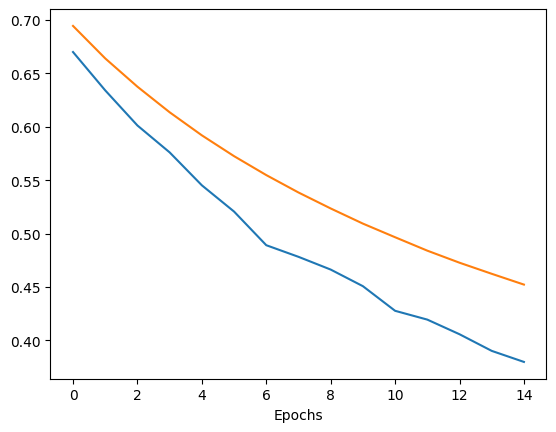

In [65]:
fig = plt.figure()
plt.plot(loss_train[1:])
plt.plot(loss_eval[1:])
plt.xlabel('Epochs')
plt.show()

In [66]:
model_1.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model_1(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target

In [67]:
metrics.confusion_matrix(ytrue,lres)

array([[31,  0],
       [ 9, 22]])

In [68]:
print(metrics.classification_report(ytrue,lres))


              precision    recall  f1-score   support

           0       0.78      1.00      0.87        31
           1       1.00      0.71      0.83        31

    accuracy                           0.85        62
   macro avg       0.89      0.85      0.85        62
weighted avg       0.89      0.85      0.85        62



GoogleNET

In [50]:
model_2 = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
model_2.fc=nn.Linear(1024,22)

In [52]:
model_2.to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(googlenet.parameters(),lr=0.1)

In [53]:
epochs = 100
loss_train = []
loss_eval  = []
stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0
while (not stop):
    model_2.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model_2(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
    loss_train.append(np.mean(lloss))
    llos = []
    model_2.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)
            pred = model_2(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'model':model_2.state_dict(),'opt':opt.state_dict(),'epoch':epoch,'loss':lowest_loss_eval,'loss_train':loss_train,'loss_eval':loss_eval}
        torch.save(actual_state,'/content/drive/MyDrive/trabia/best_model_2.pth')
    last_best_result += 1
    if last_best_result > 10:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

Best model found! saving...
epoch 0 loss_train 3.263 loss_eval 3.202 last_best 1
epoch 1 loss_train 3.271 loss_eval 3.211 last_best 2
epoch 2 loss_train 3.275 loss_eval 3.217 last_best 3
epoch 3 loss_train 3.271 loss_eval 3.220 last_best 4
epoch 4 loss_train 3.285 loss_eval 3.231 last_best 5
epoch 5 loss_train 3.279 loss_eval 3.232 last_best 6
epoch 6 loss_train 3.275 loss_eval 3.233 last_best 7
epoch 7 loss_train 3.277 loss_eval 3.237 last_best 8
epoch 8 loss_train 3.281 loss_eval 3.242 last_best 9
epoch 9 loss_train 3.274 loss_eval 3.241 last_best 10
epoch 10 loss_train 3.279 loss_eval 3.246 last_best 11


In [74]:
recover_googlenet = torch.load('/content/drive/MyDrive/trabia/best_model_2.pth')

<ipython-input-74-ccea49437684>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recover_googlenet = torch.load('/content/drive/MyDrive/trabia/best_model_2.pth')


In [75]:
recover_googlenet = torch.load('best_model_2.pth')
model_2.load_state_dict(recover_googlenet['model'])

opt = optim.SGD(model_2.parameters(), lr=0.01)

opt.load_state_dict(recover_googlenet['opt'])

loss_train = recover_googlenet['loss_train']
loss_eval = recover_googlenet['loss_eval']
epoch = recover_googlenet['epoch']
l = []
for layer in model_2.children():
    l.append(layer)

<ipython-input-75-de39972014bd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recover_googlenet = torch.load('best_model_2.pth')


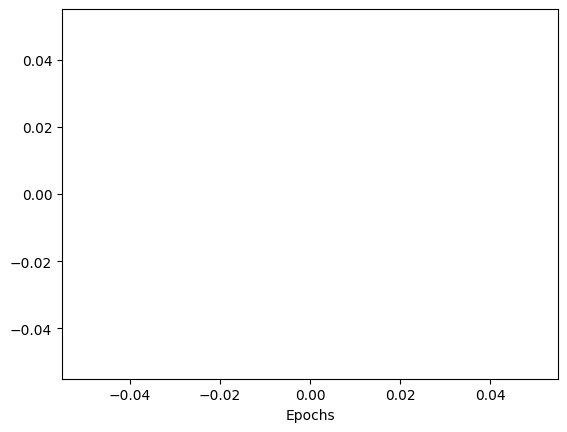

In [77]:
fig = plt.figure()
plt.plot(loss_train[1:])
plt.plot(loss_eval[1:])
plt.xlabel('Epochs')
plt.show()

In [78]:
model_2.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model_2(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target

In [79]:
metrics.confusion_matrix(ytrue,lres)

array([[ 0,  0,  7,  1,  2,  9,  2,  3,  7],
       [ 0,  2,  3,  0,  4,  3,  0,  6, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [80]:
print(metrics.classification_report(ytrue,lres))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       1.00      0.06      0.12        31
           8       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0

    accuracy                           0.03        62
   macro avg       0.11      0.01      0.01        62
weighted avg       0.50      0.03      0.06        62



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_